In [1]:
print("hello")

hello


# Evaluating When Vegetation Peaks in the City of Boulder versus Outside the City

In [13]:
# Libraries 

import json
import os
import pathlib
from pathlib import Path


import earthpy
import hvplot.xarray
import rioxarray as rxr
import xarray as xr

import geopandas as gpd
import hvplot.pandas
import holoviews as hv


from glob import glob
import pandas as pd
from shapely.geometry import mapping
import matplotlib.pyplot as plt

### open street map
from osmnx import features as osm
import osmnx as ox

### earthpy
import earthpy
#import earthpy.api.appeears as eaapp


<Axes: >

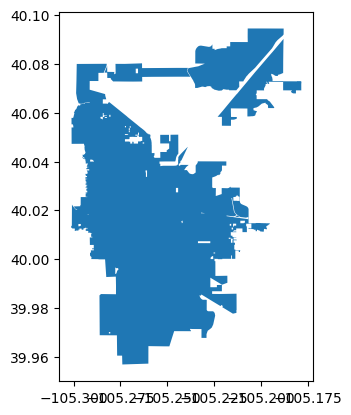

In [7]:
boulder_gdf = ox.geocode_to_gdf(
    'Boulder, Colorado, United States')

boulder_gdf

boulder_gdf.plot()

In [14]:
# Get a sorted list of NDVI tif file paths
#ndvi_paths = sorted(list(project.project_dir.rglob('MOD13Q1.061__250m_16_days_NDVI*.tif')))


ndvi_dir = Path("data/ndvi-boulder-2002-2022")

# Grab all matching files (recursively if needed)
ndvi_paths = sorted(ndvi_dir.rglob("MOD13Q1.061__250m_16_days_NDVI*.tif"))


# Display the first and last three files paths to check the pattern
ndvi_paths[:3], ndvi_paths[-3:]

([WindowsPath('data/ndvi-boulder-2002-2022/MOD13Q1.061__250m_16_days_NDVI_doy2002113000000_aid0001.tif'),
  WindowsPath('data/ndvi-boulder-2002-2022/MOD13Q1.061__250m_16_days_NDVI_doy2002129000000_aid0001.tif'),
  WindowsPath('data/ndvi-boulder-2002-2022/MOD13Q1.061__250m_16_days_NDVI_doy2002145000000_aid0001.tif')],
 [WindowsPath('data/ndvi-boulder-2002-2022/MOD13Q1.061__250m_16_days_NDVI_doy2022177000000_aid0001.tif'),
  WindowsPath('data/ndvi-boulder-2002-2022/MOD13Q1.061__250m_16_days_NDVI_doy2022193000000_aid0001.tif'),
  WindowsPath('data/ndvi-boulder-2002-2022/MOD13Q1.061__250m_16_days_NDVI_doy2022209000000_aid0001.tif')])

In [15]:
ndvi_das = []

for ndvi_path in ndvi_paths:
    # Get date from file name
    fname = ndvi_path.name  # just the filename, not the whole path
    # find the substring "doy" and take the next 7 digits (YYYYDDD)
    doy_index = fname.find("doy") + 3
    date_str = fname[doy_index:doy_index + 7]  # e.g. '2001145'
    year = int(date_str[:4])
    doy = int(date_str[4:])
    date = pd.to_datetime(f"{year}-{doy}", format="%Y-%j")
    
    # Open dataset
    da = rxr.open_rasterio(ndvi_path, masked=True).squeeze()
    
    # Add date dimension and clean up metadata 
    da = da.assign_coords({'date': date}).expand_dims({'date': [date]})
    da.name = 'NDVI'
    
    # Prepare for concatenation
    ndvi_das.append(da)

ndvi_da = xr.combine_by_coords(ndvi_das, coords=['date'])

C:\Users\matth\AppData\Local\Temp\ipykernel_11400\3803651547.py:23: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ndvi_da = xr.combine_by_coords(ndvi_das, coords=['date'])
C:\Users\matth\AppData\Local\Temp\ipykernel_11400\3803651547.py:23: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ndvi_da = xr.combine_by_coords(ndvi_das, coords=['

In [16]:
ndvi_da

<xarray.Dataset> Size: 31MB
Dimensions:      (date: 147, y: 169, x: 309)
Coordinates:
  * date         (date) datetime64[ns] 1kB 2002-04-23 2002-05-09 ... 2022-07-28
    band         int64 8B 1
  * x            (x) float64 2kB -105.7 -105.7 -105.7 ... -105.1 -105.1 -105.1
  * y            (y) float64 1kB 40.26 40.26 40.26 40.26 ... 39.92 39.92 39.91
    spatial_ref  int64 8B 0
Data variables:
    NDVI         (date, y, x) float32 31MB 278.0 278.0 ... 3.29e+03 3.29e+03

In [17]:
ndvi_diff_scaled = ndvi_da * 0.0001

difference_plot = (
    ndvi_diff_scaled.hvplot(x='x', y='y', cmap='PiYG', geo=True, 
                            title='Difference in NVDI from the 2000s to the 2010s', ylabel='Latitude', xlabel='Longitude')
    *
    boulder_gdf.hvplot(geo=True, fill_color=None, line_color='black') # add boundary
)

In [18]:
difference_plot

BokehModel(combine_events=True, render_bundle={'docs_json': {'dd800a62-377b-41f1-a2f5-1f1edec530f3': {'version…